# Установка зависимостей

In [1]:
!wget -q zaborshicov.ru/hiden/startup_train.csv
!wget -q zaborshicov.ru/hiden/startup_test.csv

In [2]:
%%capture
!pip install optuna
!pip install catboost

In [4]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from matplotlib import pyplot as plt
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import datetime

In [5]:
y_name = 'has_next_round'
RANDOM_STATE = 42

**Описание набора данных:**<p>
**Необходимо обучить алгоритм машинного обучения определять, выживет стартап или нет - задача бинарной классификации**

`index` — уникальный id стартапа; <p>
`name` — название стартапа;<p>
`overview` — описание стартапа;<p>
`category_code` — категория, в которой работает стартап;<p>
`tag_list` — список тэгов для стартапа;<p>
`country_code` — страна, в которой зарегистрирован стартап;<p>
`num_prev_rounds` — количество раундов, который к настоящему времени поднял стартап. Раунд — это получение денег от инвесторов;<p>
`has_raised_amount` — получал ли стартап до настоящего момента деньги от инвесторов;<p>
`ln_raised_amount` — логарифм суммы денег, которые стартап получил от инвесторов к настоящему моменту;<p>
`participants` — количество инвесторов, инвестировавших деньги в стартап;<p>
`previous_any_founder_experience` — был ли у основателя стартапа опыт в работе/бизнесе до основания стартапа;<p>
`ipo_prob` — вычисленное Андреем значение вероятности, что в будущем стартап попробует стать публичной компанией;<p>
`ma_prob` — вычисленное Андреем значение, что в будущем стартап будет приобретен другой компанией;<p>
`has_next_round` (целевая переменная) — выживет ли стартап.

# EDA

## Первичный анализ признаков

In [6]:
df = pd.read_csv('startup_train.csv').drop('index', axis=1)
df_test = pd.read_csv('startup_test.csv').drop('index', axis=1)
df.head()

,name,overview,category_code,tag_list,country_code,num_prev_rounds,has_raised_amount,ln_raised_amount,participants,previous_any_founder_experience,ipo_prob,ma_prob,has_next_round
0,Stackdriver,Stackdriver provides a [powerfully simple moni...,enterprise,"application-management, cloud-monitoring, moni...",USA,1,1,15.424948,1,0,0.024390,0.182927,1
1,Authix Tecnologies,Authix Tecnologies is a Torino based start-up ...,security,authentication-solution,GRC,1,1,13.340052,1,0,0.000000,0.000000,1
2,Lytics,Lytics provides B2C marketers the first analyt...,software,"analytics, big-data, data-science, bigdata",USA,2,1,14.603968,5,0,0.021505,0.242105,0
3,1World Online,1World Online is a Silicon Valley-based startu...,enterprise,"social-research, big-data, analytics, mobile",USA,1,1,13.815511,1,0,0.000000,0.000000,0
4,Enure Networks,"Enure Networks, Ltd. provides home-network man...",software,NaN,ISR,1,1,15.894952,2,0,0.000000,0.000000,1


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.nunique()

,0
name,5512
overview,5510
category_code,41
tag_list,3286
country_code,69
num_prev_rounds,10
has_raised_amount,2
ln_raised_amount,1087
participants,27
previous_any_founder_experience,2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   name                             5512 non-null   object 
 1   overview                         5510 non-null   object 
 2   category_code                    5512 non-null   object 
 3   tag_list                         3319 non-null   object 
 4   country_code                     5512 non-null   object 
 5   num_prev_rounds                  5512 non-null   int64  
 6   has_raised_amount                5512 non-null   int64  
 7   ln_raised_amount                 5512 non-null   float64
 8   participants                     5512 non-null   int64  
 9   previous_any_founder_experience  5512 non-null   int64  
 10  ipo_prob                         5512 non-null   float64
 11  ma_prob                          5512 non-null   float64
 12  has_next_round      

In [10]:
df_categorical =  ['name',
                   'overview',
                   'category_code',
                   'tag_list',
                   'country_code'
                   ]
df_numerical = ['num_prev_rounds',
                'ln_raised_amount',
                'participants',
                'ipo_prob',
                'ma_prob'
                ]
df_binary = ['previous_any_founder_experience',
             'has_raised_amount'
             ]

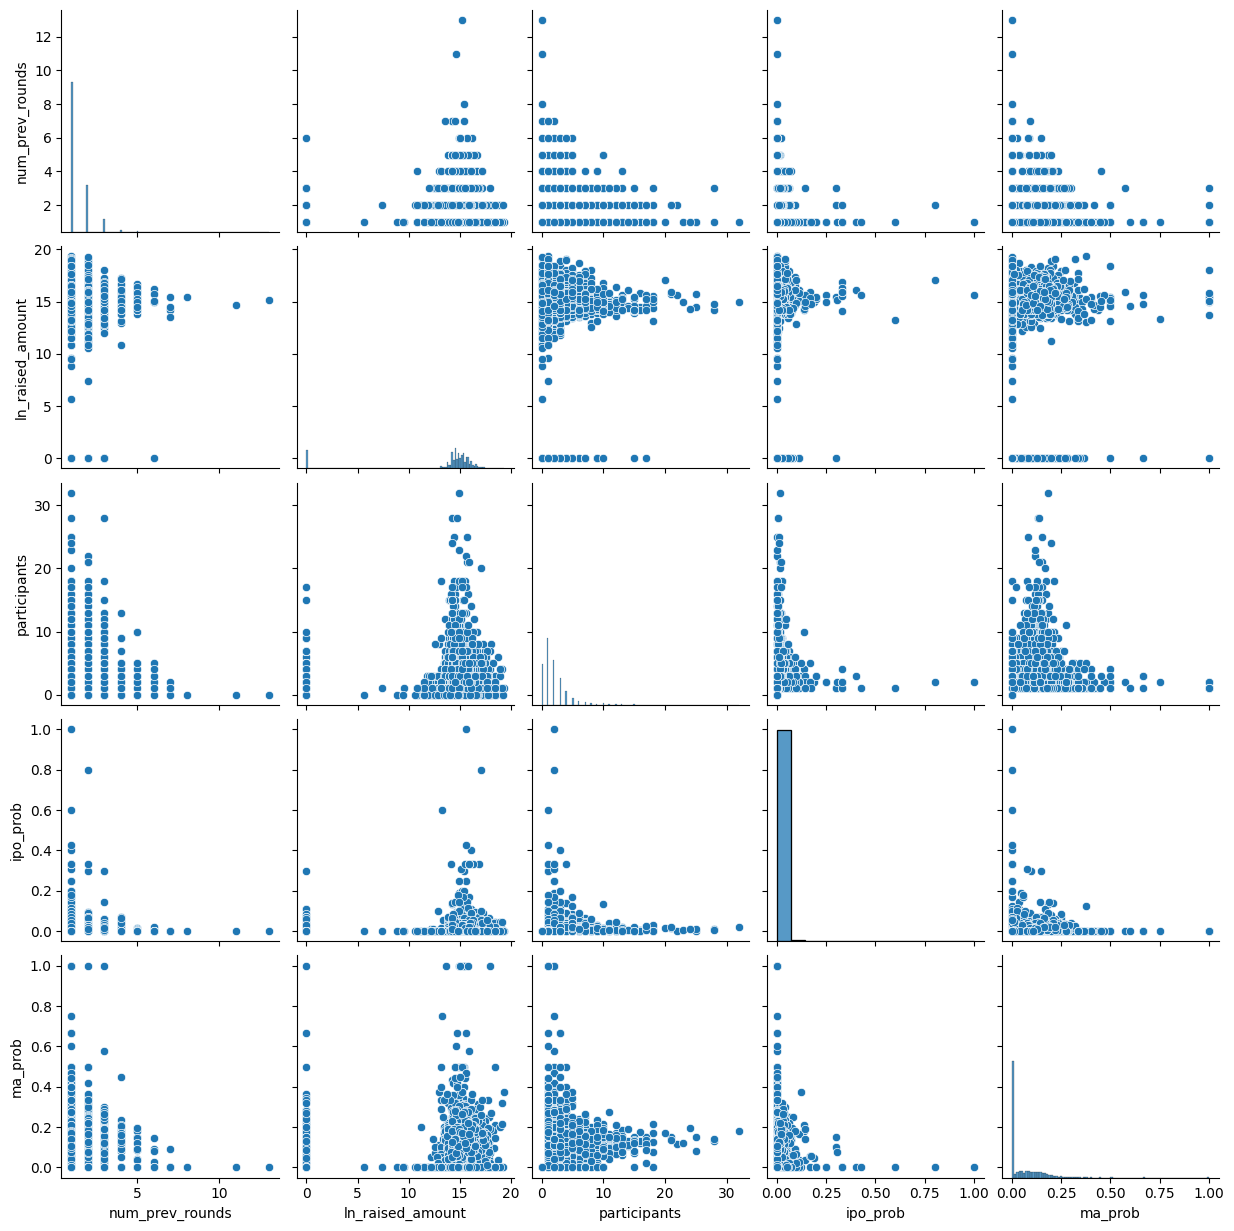

In [11]:
import seaborn as sns
sns.pairplot(df[df_numerical])

array([[<Axes: title={'center': 'num_prev_rounds'}>,
        <Axes: title={'center': 'ln_raised_amount'}>],
       [<Axes: title={'center': 'participants'}>,
        <Axes: title={'center': 'ipo_prob'}>],
       [<Axes: title={'center': 'ma_prob'}>, <Axes: >]], dtype=object)

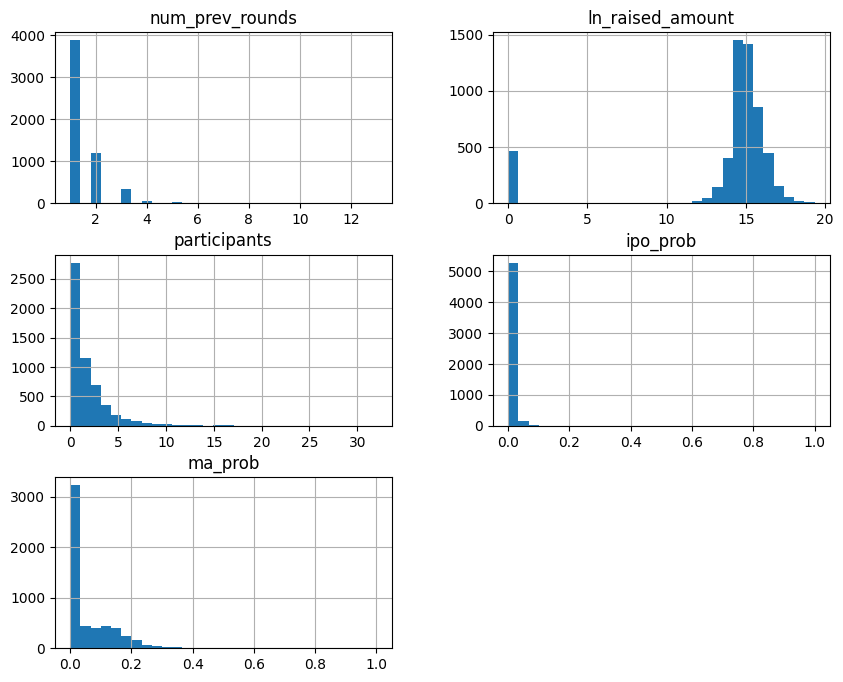

In [14]:
df[df_numerical].hist(bins=30, figsize=(10, 8))

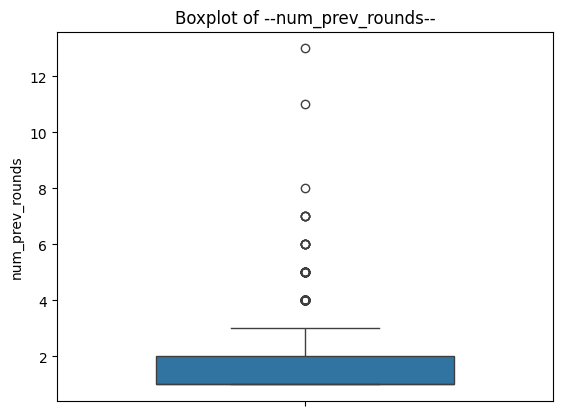

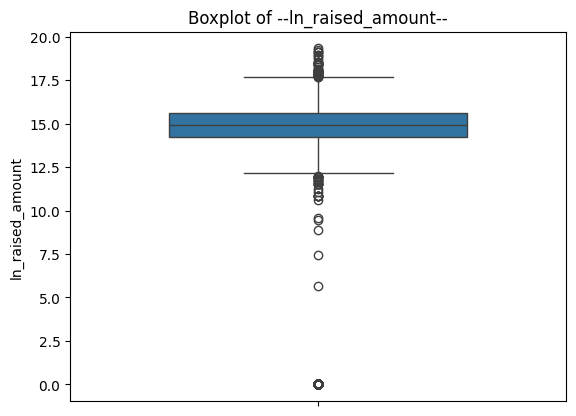

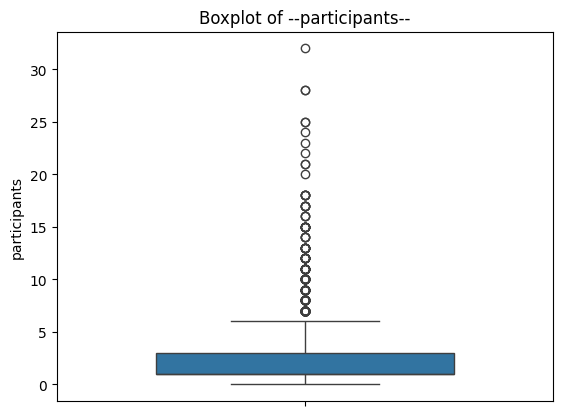

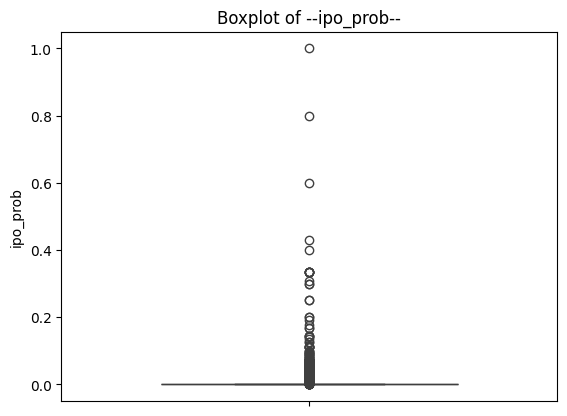

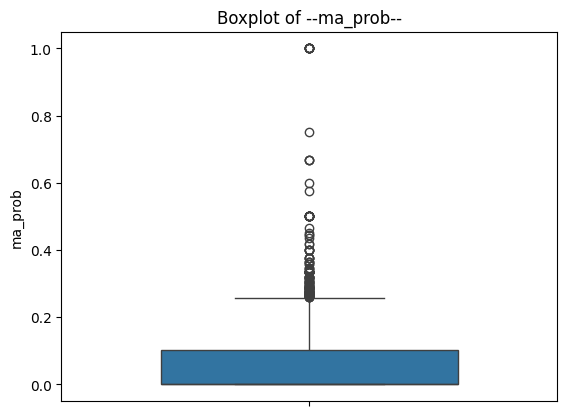

In [17]:
for col in df_numerical:
    sns.boxplot(df[col], width=0.6)
    plt.title(f'Boxplot of --{col}--')
    plt.show()

Рассмотрим "`participants`"

In [ ]:
df[['participants']].value_counts()

participants
1               1711
2               1149
0               1059
3                690
4                355
5                181
6                109
7                 74
8                 40
10                38
9                 29
11                17
12                12
15                10
13                10
17                 5
18                 5
14                 4
16                 3
21                 2
25                 2
28                 2
20                 1
22                 1
23                 1
24                 1
32                 1
Name: count, dtype: int64

In [ ]:
df.groupby(['participants', 'has_next_round']).agg({'has_next_round': 'count'}).tail(10)

has_next_round
participants has_next_round                
18           1                            1
20           1                            1
21           0                            2
22           0                            1
23           0                            1
24           0                            1
25           0                            2
28           0                            1
             1                            1
32           0                            1

Выводы: при большом количестве инвесторов почти всегда стартап не проходит дальше, отметим 25-32 - выбросом

In [18]:
df = df[df['participants'] < 25]
df.shape

(5507, 13)

Анализ "`num_prev_r"ounds`"

In [ ]:
df.groupby(['num_prev_rounds', 'has_next_round']).agg({'has_next_round': 'count'})

has_next_round
num_prev_rounds has_next_round                
1               0                         1890
                1                         1979
2               0                          677
                1                          531
3               0                          213
                1                          127
4               0                           33
                1                           18
5               0                           14
                1                           12
6               0                            3
                1                            3
7               0                            3
                1                            1
8               1                            1
11              0                            1
13              1                            1

In [ ]:
df = df[df['num_prev_rounds'] <= 10]
df.shape

(5505, 13)

Рассмотрим ipo_prob, ma_prob

In [ ]:
df[['ipo_prob', 'ma_prob', 'has_next_round']].corr()

,ipo_prob,ma_prob,has_next_round
ipo_prob,1.000000,0.087640,0.020088
ma_prob,0.087640,1.000000,-0.036611
has_next_round,0.020088,-0.036611,1.000000


In [ ]:
df[df['ln_raised_amount'] == 0]['has_next_round'].value_counts(normalize=True)

has_next_round
0    0.66167
1    0.33833
Name: proportion, dtype: float64

Рссмотрим пропуски в датасете. Это позволяет понять, как нам надо предобрабатывать данные и, в целом, взаимодействовать с ними. Как мы видим - пропусков в данных мало, однако часто пропущены тэги.

In [ ]:
df.isna().sum()

name                                  0
overview                              2
category_code                         0
tag_list                           2191
country_code                          0
num_prev_rounds                       0
has_raised_amount                     0
ln_raised_amount                      0
participants                          0
previous_any_founder_experience       0
ipo_prob                              0
ma_prob                               0
has_next_round                        0
dtype: int64

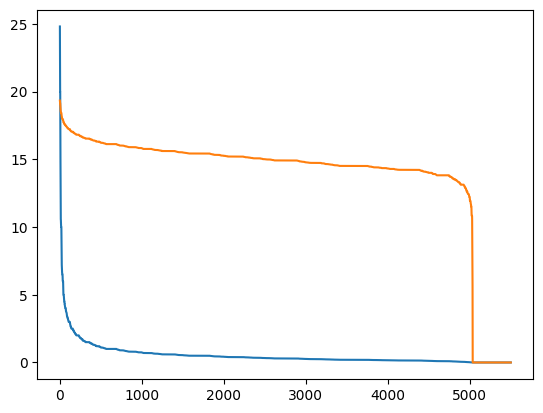

In [ ]:
money = df['ln_raised_amount'].sort_values(ascending=False).reset_index().drop('index', axis=1).values.flatten()
plt.plot(np.exp(money)*1e-7)
plt.plot(money)

# Генерация фичей

In [19]:
def extra_data(df_extended: pd.DataFrame) -> pd.DataFrame:
  # колонка с количеством тегов + клолнка с отсутствием тегов отдельно
  df_extended['count_of_tags'] = df.tag_list.str.count(',') + 1
  df_extended['count_of_tags'][df.tag_list.isna()] = 0
  df_extended['no_tags'] = df['tag_list'].isna()

  # пороги денежных масс, вложенных в стартап
  df_extended['no_money'] = df['ln_raised_amount'] == 0
  df_extended['many_money'] = df['ln_raised_amount'] > money[5000]
  df_extended['realy_a_lot_of_money'] = df['ln_raised_amount'] > money[5300]
  df_extended['little_money'] = df['ln_raised_amount'] < money[1000]
  df_extended['little_money'] = df['ln_raised_amount'] < money[1000]
  df_extended['too_little_money'] = df['ln_raised_amount'] < money[750]

  # длина описания
  df_extended['overview_length'] = df.overview.str.count(' ') + 1
  df_extended['overview_length'][df.overview.isna()] = 0
  df_extended['small_length'] = df_extended['overview_length'] < 20
  df_extended['large_length'] = df_extended['overview_length'] > 200
  df_extended['too_large_length'] = df_extended['overview_length'] > 300

  # сколько в среднем вложился 1 учасник
  df_extended['ln_raised_amount/participants'] = np.exp(df_extended['ln_raised_amount'])/(df_extended['participants'] + 1)

  df_extended['no_invest'] = df['participants'] == 0
  df_extended['len'] = df.name.str.len()
  df_extended['tooshort'] = df_extended['len'] <= 2
  df_extended['short'] = df_extended['len'] <= 5
  df_extended['numinname'] = df['name'].str.extract('(\d+)').isna()
  df_extended['large'] = df_extended['len'] >= 10
  df_extended['toolarge'] = df_extended['len'] >= 25

  # признаки, полученные ранее
  df_extended['ipo_ma_prob_sum'] = df['ipo_prob'] - df['ma_prob']
  df_extended['ipo_ma_prob_prod'] = df['ipo_prob'] * df['ma_prob']

  return df_extended

In [ ]:
df_extended = df.copy()
df_extended = extra_data(df_extended)

df_extended_test = df_test.copy()
df_extended_test = extra_data(df_extended_test)

In [ ]:
df_extended_num = df_extended.select_dtypes(exclude=['object']).columns
df_extended_num

Index(['num_prev_rounds', 'has_raised_amount', 'ln_raised_amount',
       'participants', 'previous_any_founder_experience', 'ipo_prob',
       'ma_prob', 'has_next_round', 'count_of_tags', 'no_tags', 'no_money',
       'many_money', 'realy_a_lot_of_money', 'little_money',
       'too_little_money', 'overview_length', 'small_length', 'large_length',
       'too_large_length', 'ln_raised_amount/participants', 'no_invest', 'len',
       'tooshort', 'short', 'numinname', 'large', 'toolarge',
       'ipo_ma_prob_sum', 'ipo_ma_prob_prod'],
      dtype='object')

<Axes: >

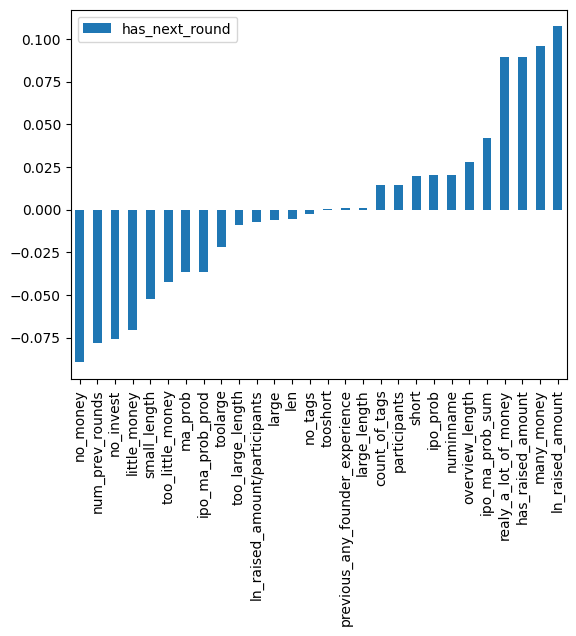

In [ ]:
df_extended[df_extended_num].corr()[['has_next_round']].drop('has_next_round').sort_values(by='has_next_round').plot.bar()

<Axes: >

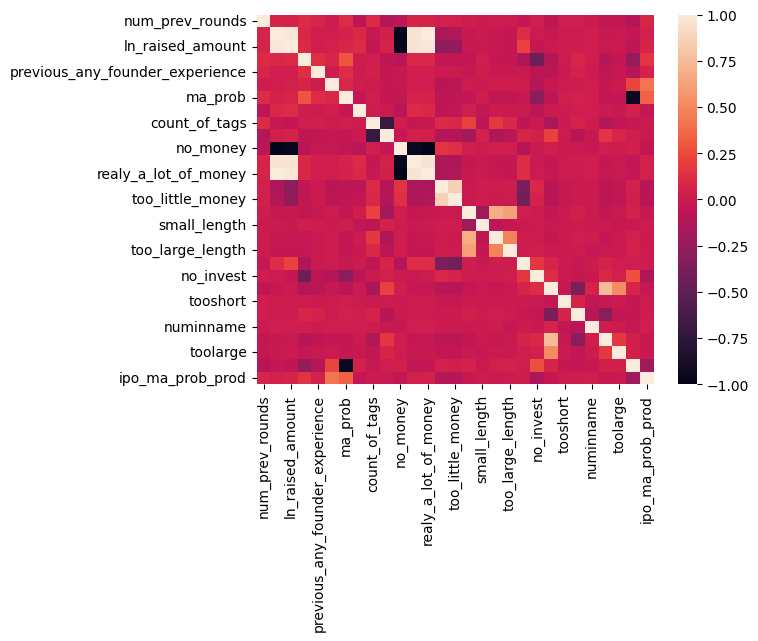

In [ ]:
sns.heatmap(df_extended[df_extended_num].corr())

# Models



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_extended.drop(y_name, axis=1), df_extended.has_next_round, test_size=0.25, random_state=random_state)

In [ ]:
df_extended['overview'] = df_extended['overview'].apply(str)
df_extended['name'] = df_extended['name'].apply(str)
df_extended['tag_list'] = df_extended['tag_list'].apply(str)

In [ ]:
df_text =  ['name', 'overview', 'tag_list']
df_cat = ['category_code', 'country_code']

In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
def objective_catboost(trial):
    param = {
        "depth": trial.suggest_int("depth", 2, 10),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01),
        'random_strength': trial.suggest_int('random_strength', 0, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
    }

    estimator = CatBoostClassifier(**param, random_state=RANDOM_STATE, cat_features=df_cat, text_features=df_text, verbose=False, task_type='GPU')

    estimator.fit(X_train, y_train)
    score = accuracy_score(y_test, estimator.predict(X_test))
    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=30)
study.best_trial

In [ ]:
model_cb = CatBoostClassifier(**study.best_params, random_state=random_state, cat_features=df_cat, text_features=df_text)
model_cb.fit(df_extended.drop(y_name, axis=1), df_extended.has_next_round)

In [ ]:
pd.DataFrame(model_cb.feature_importances_, df_extended.drop('has_next_round', axis=1).columns).sort_values(by=0, ascending=False)

,0
overview,46.444948
country_code,18.427806
ln_raised_amount,9.161306
ma_prob,4.759672
participants,4.049650
category_code,3.234034
num_prev_rounds,3.171040
ipo_ma_prob_sum,2.470911
ln_raised_amount/participants,2.296051
tag_list,1.582412


In [ ]:
df_extended_new = df_extended.drop(columns=['large_length','previous_any_founder_experience', 'tooshort'], axis=1)

In [ ]:
model_cb.fit(df_extended_new.drop(y_name, axis=1), df_extended_new.has_next_round)

In [ ]:
df_extended_test['overview'] = df_extended_test['overview'].apply(str)
df_extended_test['name'] = df_extended_test['name'].apply(str)
df_extended_test['tag_list'] = df_extended_test['tag_list'].apply(str)

In [ ]:
df_extended_test_new = df_extended_test.drop(columns=['large_length','previous_any_founder_experience', 'tooshort'], axis=1)

In [ ]:
pred = model_cb.predict(df_extended_test_new)